# The 2-dim *Donut* example

*last tested with bayesfast commit 5810931*

In [1]:
import bayesfast as bf
import numpy as np
from threadpoolctl import threadpool_limits
threadpool_limits(1) # TODO: implement a bayesfast global thread controller

In [2]:
a = 5
b = 0.5

def f_0(x):
    return np.linalg.norm(x, 2, -1)

def j_0(x):
    '''not actually used'''
    foo = x / np.linalg.norm(x, 2, -1)
    return foo if np.all(np.isfinite(foo)) else np.ones_like(foo)

def f_1(x):
    return -(x - a)**2 / b

def j_1(x):
    return -2 * (x - a) / b

In [3]:
bf.utils.random.set_generator(2) # set up the global random number generator
bf.utils.parallel.set_backend(8) # set up the global parallel backend

module_0 = bf.Module(fun=f_0, input_vars='x', output_vars='m')
module_1 = bf.Module(fun=f_1, jac=j_1, input_vars='m', output_vars='logp')

density_0 = bf.Density(module_list=[module_0, module_1], input_shapes=[2],
                       input_vars='x', density_name='logp')
density_0.set_decay_options(use_decay=True)

surro_0 = bf.modules.PolyModel('linear', input_size=2, output_size=1,
                               input_vars='x', output_vars='m')
surro_1 = bf.modules.PolyModel('quadratic', input_size=2, output_size=1,
                               input_vars='x', output_vars='m')
surro_1.set_bound_options(use_bound=False)

x_0 = bf.utils.sobol.multivariate_normal([10, 10], np.eye(2), 20)

sample_trace = {'n_chain': 8, 'n_iter': 1000, 'n_warmup': 500}

opt_0 = bf.recipe.OptimizeStep(surrogate_list=surro_0, x_0=x_0,
                               sample_trace=sample_trace)
sam_0 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=5, reuse_samples=0,
                             sample_trace=sample_trace, logp_cutoff=False)
sam_1 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=5, reuse_samples=1,
                             sample_trace=sample_trace, logp_cutoff=False)

rec_0 = bf.recipe.Recipe(density=density_0, optimize=opt_0,
                         sample=[sam_0, sam_1], post={},
                         sample_multiplicity=[5, 5])

In [4]:
rec_0.run()

 OptimizeStep proceeding: iter #0 finished, while current logp = -1.870, logp_trans = -1.870, delta_pq = 10.181.
 OptimizeStep proceeding: iter #1 finished, while current logp = -1.497, logp_trans = -1.497, delta_pp = 0.373, delta_pq = 0.009.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:160: RuntimeWarning: the optimization stopped at [5.33912727 2.42802113], but maybe it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #2 finished, while current logp = -1.201, logp_trans = -1.201, delta_pp = 0.297, delta_pq = 0.000.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:160: RuntimeWarning: the optimization stopped at [5.25678624 2.39071015], but maybe it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #3 finished, while current logp = -1.201, logp_trans = -1.201, delta_pp = 0.000, delta_pq = 0.004.
 OptimizeStep proceeding: we will use iter #2 as it has the highest logp_trans.



/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:160: RuntimeWarning: the optimization stopped at [5.25678624 2.39071015], but maybe it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 CHAIN #7 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.83 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 200 / 1000 ], last 200 samples used 3.46 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 200 / 1000 ], last 200 samples used 3.56 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 200 / 1000 ], last 200 samples used 3.59 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 200 / 1000 ], last 200 samples used 3.85 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 200 / 1000 ], last 200 samples used 3.99 seconds. (warmup)
 CHAIN #4 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.11 seconds. (warmup)
 CHAIN #6 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.30 seconds. (warmup)
 CHAIN #7 : sampling proceeding [ 400 / 1000 ], last 200 samples used 4.50 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 400 / 1000 ], last 200 samples used 3.96 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 400 / 1000 ], last 200 samples used 

/global/u2/h/hejia/bayesfast/bayesfast/core/recipe.py:1195: RuntimeWarning: as of now, n_call does not take the possible logp calls during evidence evaluation into account.
  RuntimeWarning)


In [5]:
rec_0.get()._fields

('samples',
 'weights',
 'weights_trunc',
 'logp',
 'logq',
 'logz',
 'logz_err',
 'x_p',
 'x_q',
 'logp_p',
 'logq_q',
 'trace_p',
 'trace_q',
 'n_call',
 'x_max',
 'f_max')

In [6]:
rec_0.get().n_call

330

Removed no burn in


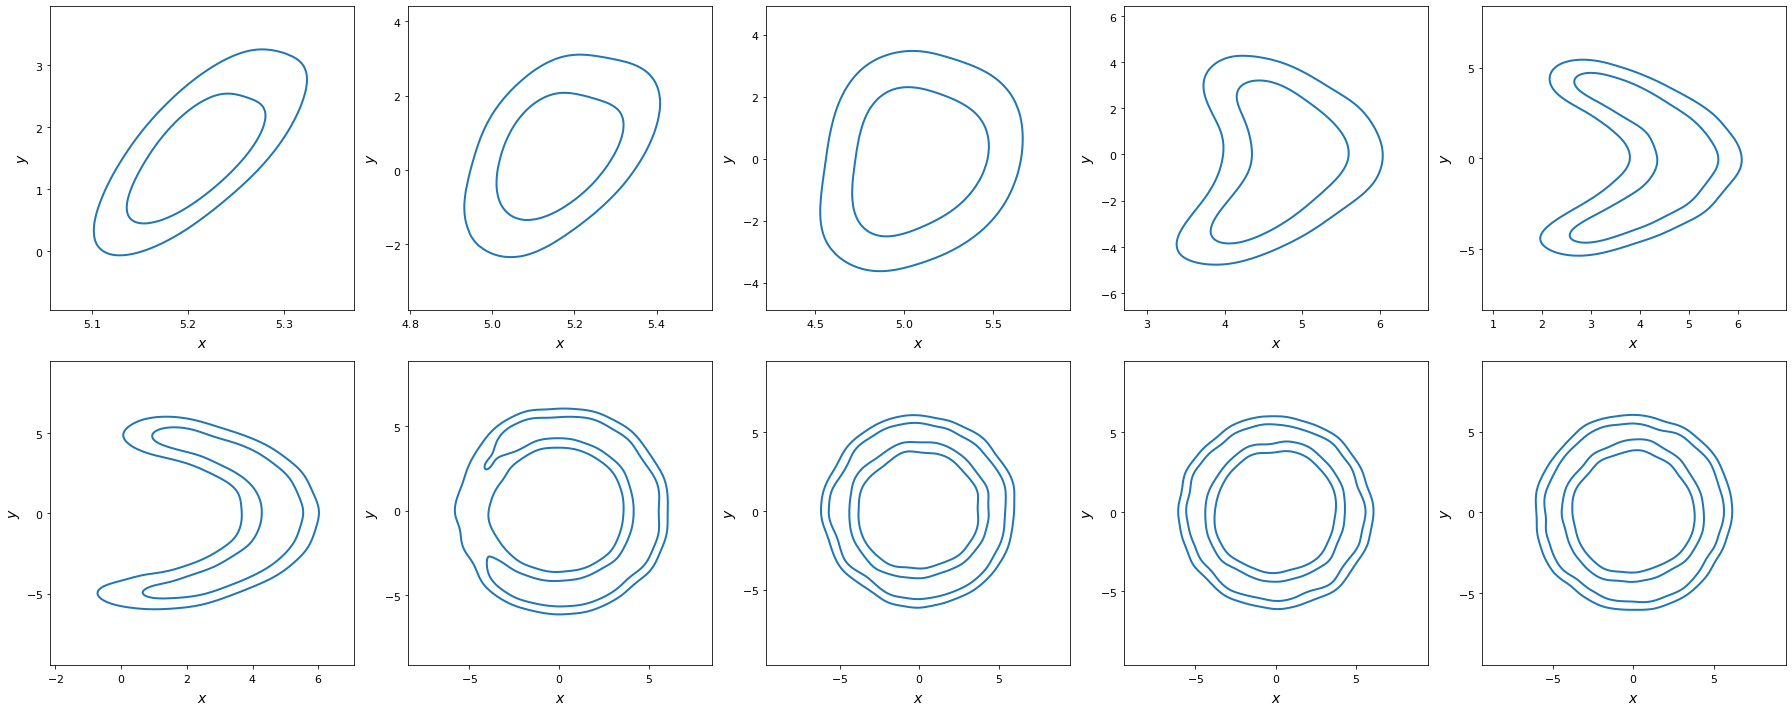

In [7]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

g = plots.get_subplot_plotter(subplot_size=5)
sa = MCSamples(samples=np.concatenate([si.samples.reshape((-1, 2)) for si in 
               rec_0.recipe_trace.results.sample], axis=-1),
               names=['x_{}'.format(i) for i in range(20)],
               labels=['x', 'y'] * 10)
g.plots_2d(sa, param_pairs=[['x_{}'.format(i), 'x_{}'.format(i + 1)] for i in 
           range(0, 20, 2)], nx=5, colors=['tab:blue'], lws=[2])

plt.show()